In [2]:
#転移学習の実行プログラム（VGG16をベースとして性別を判定するCNN）

from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger
import os
import json
import pickle
from datetime import datetime
import math
 
#①既存モデルの改良

# `include_top=False`として既存モデルの出力層を消す。
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# モデルを編集する。
model = Sequential(vgg16.layers)

    # 全19層のうち15層目までは再学習しないようにパラメータを固定する。
for layer in model.layers[:15]:
    layer.trainable = False
    # 出力層の部分を追加
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 最適化アルゴリズムをSGD（確率的勾配降下法）とし最適化の学習率と修正幅を指定してコンパイルする。
model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

#②学習素材取り込みの準備

# 学習画像を取り込むジェネレータを作成。それぞれのパラメータを設定
img_gen = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

# 画像を取り込むためのイテレータを生成（訓練データとバリデーションデータ）
train_itr = img_gen.flow_from_directory(
    'img/male_female/train', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)
val_itr = img_gen.flow_from_directory(
    'img/male_female/validation', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

#③モデルデータの保存準備

# モデル保存用のディレクトリを準備
model_dir = os.path.join(
    'models', 
    datetime.now().strftime('%y%m%d_%H%M')
)

os.makedirs(model_dir, exist_ok=True)
dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

# ネットワークの保存
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)
# 学習時の正解ラベルの保存
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb') as f:
    pickle.dump(train_itr.class_indices, f)
    
# 1エポックのバッチ数を算出    
# ceilは与えられた数以上の最小整数を出力する関数
batch_size = 16
steps_per_epoch = math.ceil(
    train_itr.samples/batch_size
)
validation_steps = math.ceil(
    val_itr.samples/batch_size
)

#④Callbacksの設定
# ここでは重みを５エポックごとに保存する設定
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='loss', 
                     verbose=0,
                     save_best_only=False, 
                     save_weights_only=True, 
                     mode='auto', 
                     period=5
                     )
csv_filepath =  os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

# ⑤学習の実行
history = model.fit_generator(
    train_itr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=1,  # 学習するエポック数
    validation_data=val_itr, 
    validation_steps=validation_steps,
    callbacks = [cp, csv]
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/1
38/38 [==============================]38/38 [==============================] - 780s 21s/step - loss: 0.6511 - acc: 0.6184 - val_loss: 0.5616 - val_acc: 0.7400



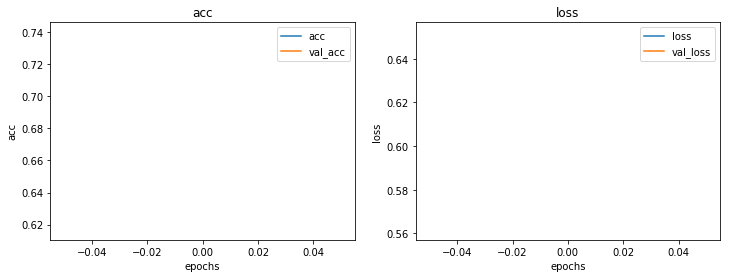

In [3]:
# 学習結果曲線の表示
%matplotlib inline
from utils import plot_learningcurve_from_csv

plot_learningcurve_from_csv(csv_filepath)

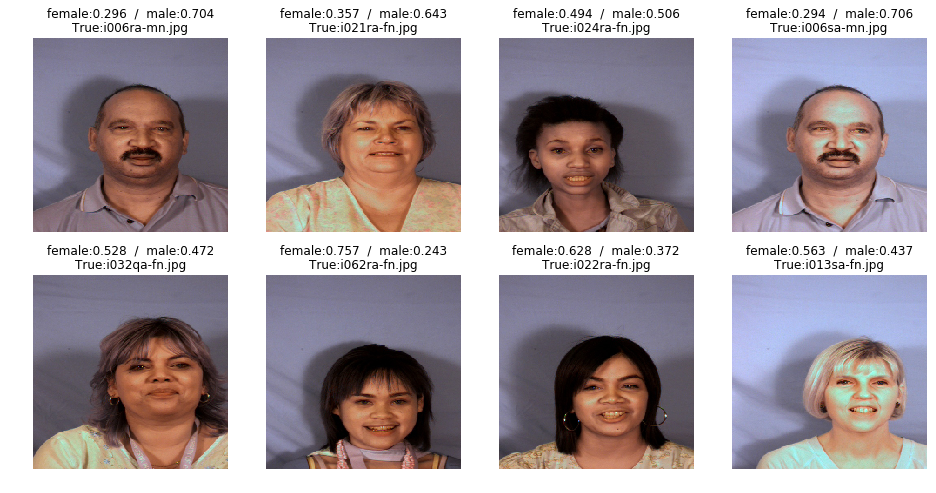

In [6]:
#テスト用プログラム

from utils import load_random_imgs, show_test_samples

# 評価の実施
test_data_dir = 'img/male_female/test'
x_test, true_labels = load_random_imgs(
    test_data_dir, 
    seed=1
)
x_test_preproc = preprocess_input(x_test.copy())/255.
probs = model.predict(x_test_preproc)

# 評価結果の表示
show_test_samples(
    x_test, probs, 
    train_itr.class_indices, 
    true_labels
)